---
## 02_Snapshot_EDA
---

In [1]:
# Imports and Load Cleaned Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# File paths (adjust if needed)
data_path = "../data/clean/"

files = {
    "internet": "internet_clean.csv",
    "mobile": "mobile_clean.csv",
    "electricity": "electricity_clean.csv",
    "literacy": "literacy_clean.csv",
    "tertiary": "tertiary_clean.csv",
    "researchers": "researchers_clean.csv",
    "rnd_gdp": "rnd_gdp_clean.csv",
    "gdp_ppp": "gdp_ppp_clean.csv",
    "gov_effect": "gov_effect_clean.csv",
}

# Load all cleaned datasets into a dictionary of DataFrames
clean_dfs = {name: pd.read_csv(data_path + fname) for name, fname in files.items()}

# Quick check: show dataset names and shapes
for name, df in clean_dfs.items():
    print(f"{name}: {df.shape}")


internet: (9310, 5)
mobile: (9310, 5)
electricity: (9310, 5)
literacy: (9310, 5)
tertiary: (9310, 5)
researchers: (9310, 5)
rnd_gdp: (9310, 5)
gdp_ppp: (9310, 5)
gov_effect: (5350, 5)


In [2]:
# Null Value Check + Data Preview

for name, df in clean_dfs.items():
    print(f"\n=== {name.upper()} ===")
    print(df.head(3))  # quick peek at first 3 rows
    print("\nNull values per column:")
    print(df.isnull().sum())
    print("-" * 50)


=== INTERNET ===
                  Country Name Country Code    Year Indicator  Value
0                        Aruba          ABW  1990.0  internet    0.0
1  Africa Eastern and Southern          AFE  1990.0  internet    NaN
2                  Afghanistan          AFG  1990.0  internet    0.0

Null values per column:
Country Name       0
Country Code       0
Year               0
Indicator          0
Value           3172
dtype: int64
--------------------------------------------------

=== MOBILE ===
                  Country Name Country Code    Year Indicator     Value
0                        Aruba          ABW  1990.0    mobile  0.000000
1  Africa Eastern and Southern          AFE  1990.0    mobile  0.002582
2                  Afghanistan          AFG  1990.0    mobile  0.000000

Null values per column:
Country Name      0
Country Code      0
Year              0
Indicator         0
Value           893
dtype: int64
--------------------------------------------------

=== ELECTRICITY ==

In [3]:
# Summary of Null Values (%)

null_summary = pd.DataFrame({
    name: (df.isnull().sum() / len(df) * 100).round(2)
    for name, df in clean_dfs.items()
}).T

null_summary.columns = df.columns  # keep same column names
null_summary

,Country Name,Country Code,Year,Indicator,Value
internet,0.0,0.0,0.0,0.0,34.07
mobile,0.0,0.0,0.0,0.0,9.59
electricity,0.0,0.0,0.0,0.0,15.59
literacy,0.0,0.0,0.0,0.0,75.06
tertiary,0.0,0.0,0.0,0.0,38.27
researchers,0.0,0.0,0.0,0.0,74.49
rnd_gdp,0.0,0.0,0.0,0.0,67.11
gdp_ppp,0.0,0.0,0.0,0.0,9.12
gov_effect,0.0,0.0,0.0,0.0,0.00


---
### Note: Coverage pre merge
---

Strong coverage (<15% nulls): gov_effect, gdp_ppp, mobile, electricity

Medium coverage (30–40% nulls): internet, tertiary

Weak coverage (>65% nulls): literacy, researchers, rnd_gdp

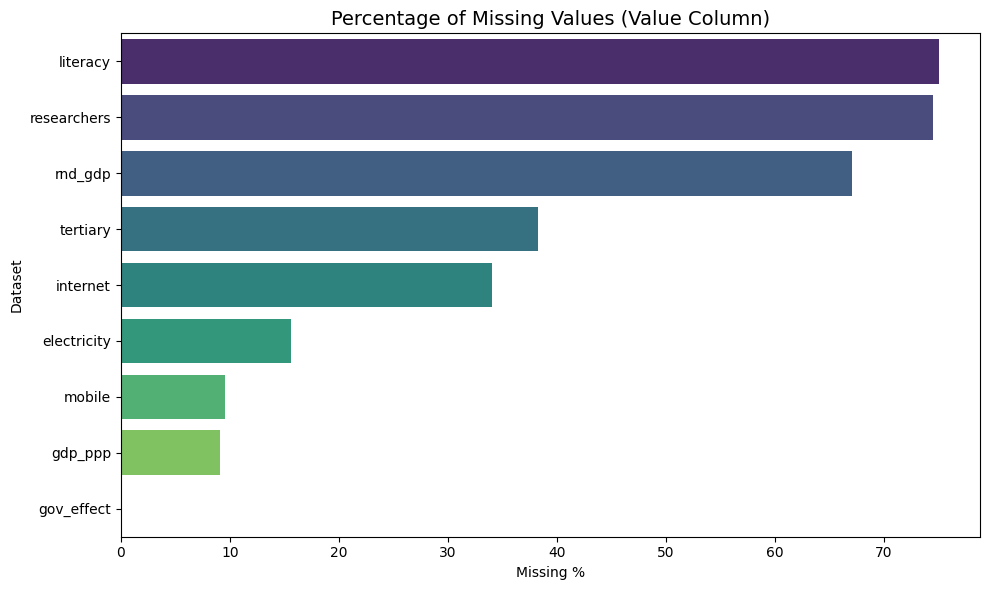

In [5]:
# Bar Chart of Null % in Value Column (with save)

missing_vals = null_summary["Value"].sort_values(ascending=False).reset_index()
missing_vals.columns = ["Dataset", "Missing %"]

plt.figure(figsize=(10,6))
sns.barplot(
    data=missing_vals,
    x="Missing %",
    y="Dataset",
    hue="Dataset",        # map palette to dataset names
    palette="viridis",
    legend=False
)

plt.title("Percentage of Missing Values (Value Column)", fontsize=14)
plt.xlabel("Missing %")
plt.ylabel("Dataset")

plt.tight_layout()

# Save to images folder
plt.savefig("../images/missing_values_bar.png", dpi=300)
plt.show()

In [7]:
# Merge all datasets into one wide-format DataFrame

# Ensure all Value columns are numeric
for name, df in clean_dfs.items():
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

# Combine all datasets into one long DataFrame
combined_long = pd.concat(clean_dfs.values(), ignore_index=True)

# Pivot to wide format: one row per country-year, indicators as columns
combined_wide = combined_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Indicator",
    values="Value",
    aggfunc="mean"   # in case duplicates exist
).reset_index()

# Quick check
print(combined_wide.shape)
combined_wide.head()

(9399, 12)


Indicator,Country Name,Country Code,Year,electricity,gdp_ppp,gov_effect,internet,literacy,mobile,researchers,rnd_gdp,tertiary
0,Afghanistan,AFG,1990.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,2.46528
1,Afghanistan,AFG,1991.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,Afghanistan,AFG,1992.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,Afghanistan,AFG,1993.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,Afghanistan,AFG,1994.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


=== Null Percentage in Combined Wide Dataset ===
Indicator
Country Name     0.00
Country Code     0.00
Year             0.00
electricity     16.38
gdp_ppp          9.98
gov_effect      45.54
internet        34.70
literacy        75.30
mobile          10.45
researchers     74.73
rnd_gdp         67.42
tertiary        38.86
dtype: float64


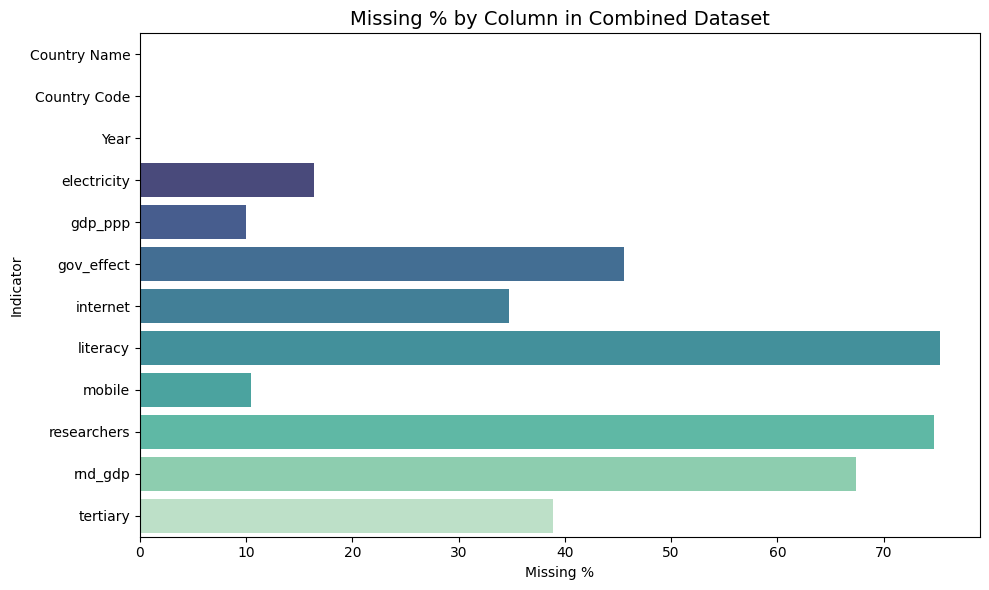

In [9]:
# Null percentage check on merged dataset

nulls_wide = (combined_wide.isnull().sum() / len(combined_wide) * 100).round(2)
print("=== Null Percentage in Combined Wide Dataset ===")
print(nulls_wide)

# Prepare data for plotting
nulls_wide_df = nulls_wide.reset_index()
nulls_wide_df.columns = ["Indicator", "Missing %"]

plt.figure(figsize=(10,6))
sns.barplot(
    data=nulls_wide_df,
    x="Missing %",
    y="Indicator",
    hue="Indicator",    # assign palette properly
    palette="mako",
    legend=False
)

plt.title("Missing % by Column in Combined Dataset", fontsize=14)
plt.xlabel("Missing %")
plt.ylabel("Indicator")

plt.tight_layout()
plt.savefig("../images/missing_values_combined_wide.png", dpi=300)
plt.show()

---
## Note: Coverage after Merge
---
Strong (≤15% missing): gdp_ppp, mobile, electricity

Medium (30–45% missing): internet, tertiary, gov_effect

Weak (≥65% missing): literacy, researchers, rnd_gdp

---
## Strong Coverage Indicator EDA
---

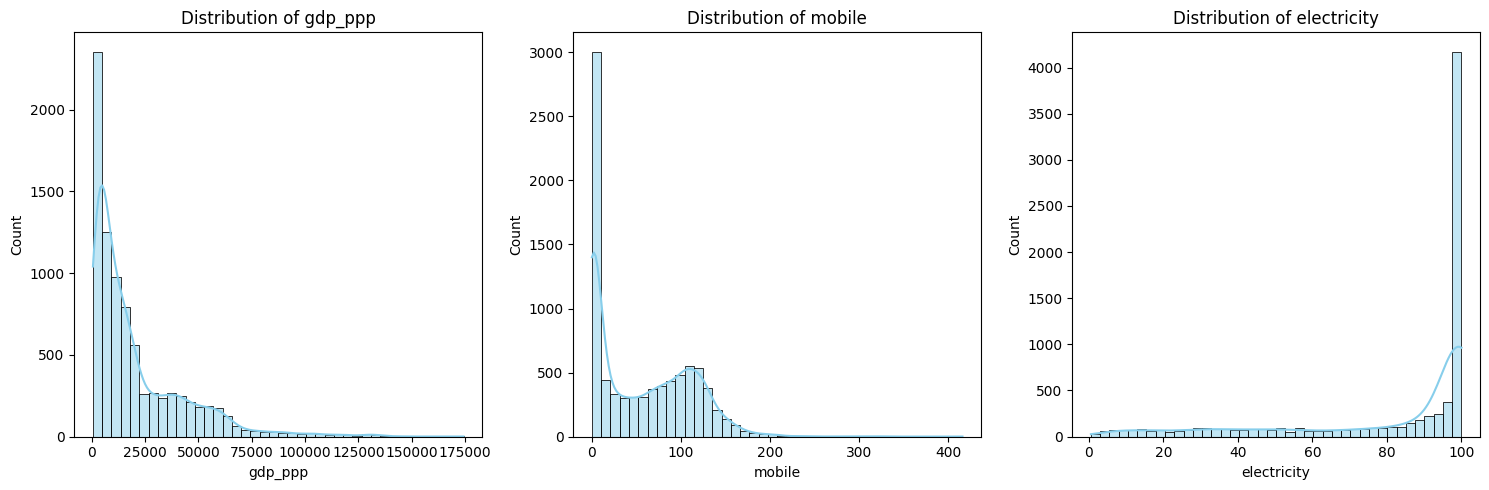

In [10]:
# Distributions of Strong Indicators

strong_indicators = ["gdp_ppp", "mobile", "electricity"]

plt.figure(figsize=(15, 5))

for i, col in enumerate(strong_indicators, 1):
    plt.subplot(1, 3, i)
    sns.histplot(
        data=combined_wide,
        x=col,
        kde=True,
        bins=40,
        color="skyblue"
    )
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.savefig("../images/distributions_strong_indicators.png", dpi=300)
plt.show()

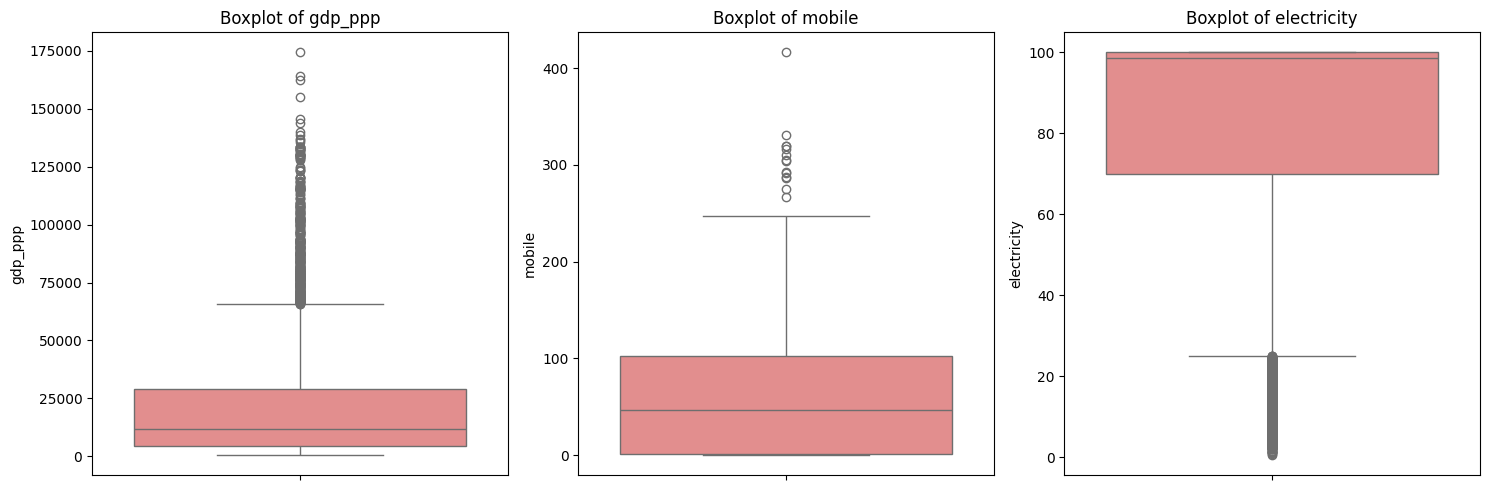

In [11]:
# Boxplots of Strong Indicators (warning-proof)

strong_indicators = ["gdp_ppp", "mobile", "electricity"]

plt.figure(figsize=(15, 5))

for i, col in enumerate(strong_indicators, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(
        data=combined_wide,
        y=col,
        color="lightcoral"   # fixed single color (no warning)
    )
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)

plt.tight_layout()
plt.savefig("../images/boxplots_strong_indicators.png", dpi=300)
plt.show()

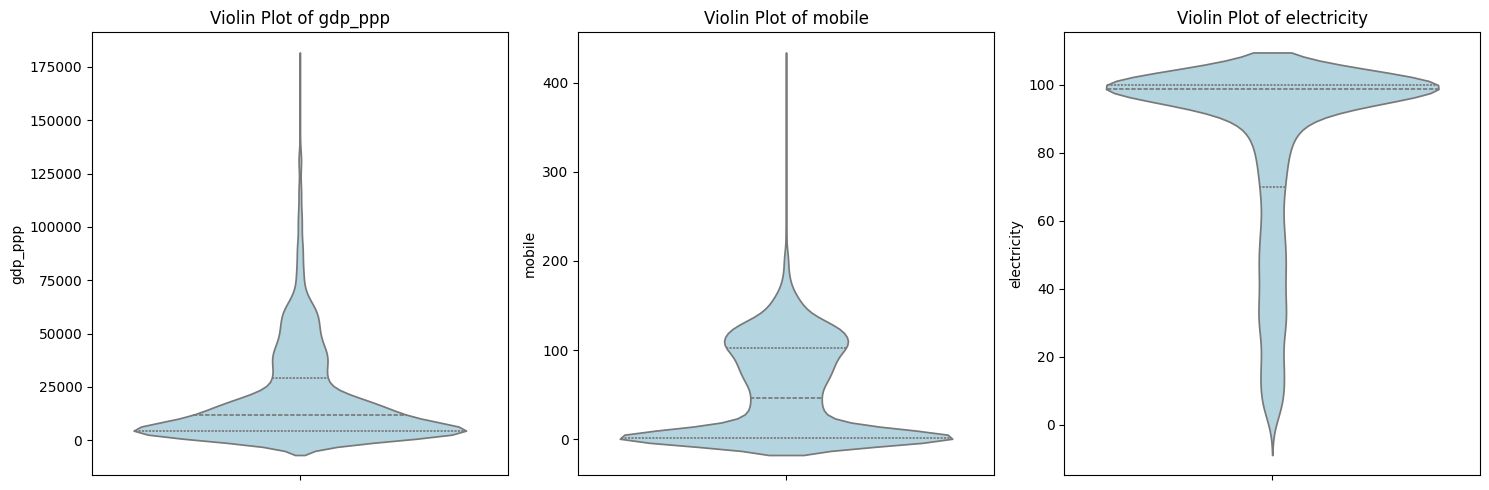

In [12]:
# Violin plots of Strong Indicators (warning-proof)

strong_indicators = ["gdp_ppp", "mobile", "electricity"]

plt.figure(figsize=(15, 5))

for i, col in enumerate(strong_indicators, 1):
    plt.subplot(1, 3, i)
    sns.violinplot(
        data=combined_wide,
        y=col,
        color="lightblue",    # single fixed color, no warnings
        inner="quartile"      # shows median + IQR inside the violin
    )
    plt.title(f"Violin Plot of {col}")
    plt.ylabel(col)

plt.tight_layout()
plt.savefig("../images/violinplots_strong_indicators.png", dpi=300)
plt.show()

---
## Notes
---
1. GDP_PPP (Income levels)

The violin is very bottom-heavy, with most density at the low end (<$10K PPP).

A thin but long tail stretches way up (>$100K PPP), showing a handful of very wealthy economies (think Gulf States, maybe South Africa, Mauritius).

This skew confirms: most African nations are low-to-middle income, but a few outliers pull the average up.
 For AI readiness: affordability of infrastructure and human capital will be uneven — concentrated in those outliers.

2. Mobile penetration

The distribution has two humps: one near zero (early adoption/fragile states) and another around 100–120%.

That second hump means in many countries, SIM cards per person exceed 1 (common when people own multiple prepaid lines).

This “bimodal” shape reflects the digital divide: some countries are barely connected, while others are saturated.
 For AI readiness: mobile is the single strongest entry point for scaling AI applications in Africa — but adoption is uneven across countries.

3. Electricity access

The violin shows two clusters: one at ~0–30% and another tightly around 100%.

Some countries still struggle with basic electricity, while others have near-universal access.

This bimodality underscores infrastructure inequality — a country can have smartphones but still lack reliable electricity.
 For AI readiness: electricity is a gatekeeper variable — without it, internet/mobile penetration alone won’t sustain AI-driven systems.

Why this matters for the project (EDA stage)

These shapes confirm heterogeneity — Africa isn’t moving uniformly toward readiness.

By visualizing the density + outliers, we see clusters of readiness (e.g., electricity-rich, mobile-saturated, high-income states) versus lagging clusters (low income, low electricity, low mobile).

This justifies building a composite AI readiness index — because single indicators give fragmented signals, but together they can separate “ready now” countries from “developing toward readiness.”

 In short:
These violin plots don’t just show spread — they highlight polarization. That polarization is exactly why this index matters: policymakers, investors, and researchers need a way to see where the gaps are and where growth potential is strongest.

---
## Medium Coverage Indicator EDA
---

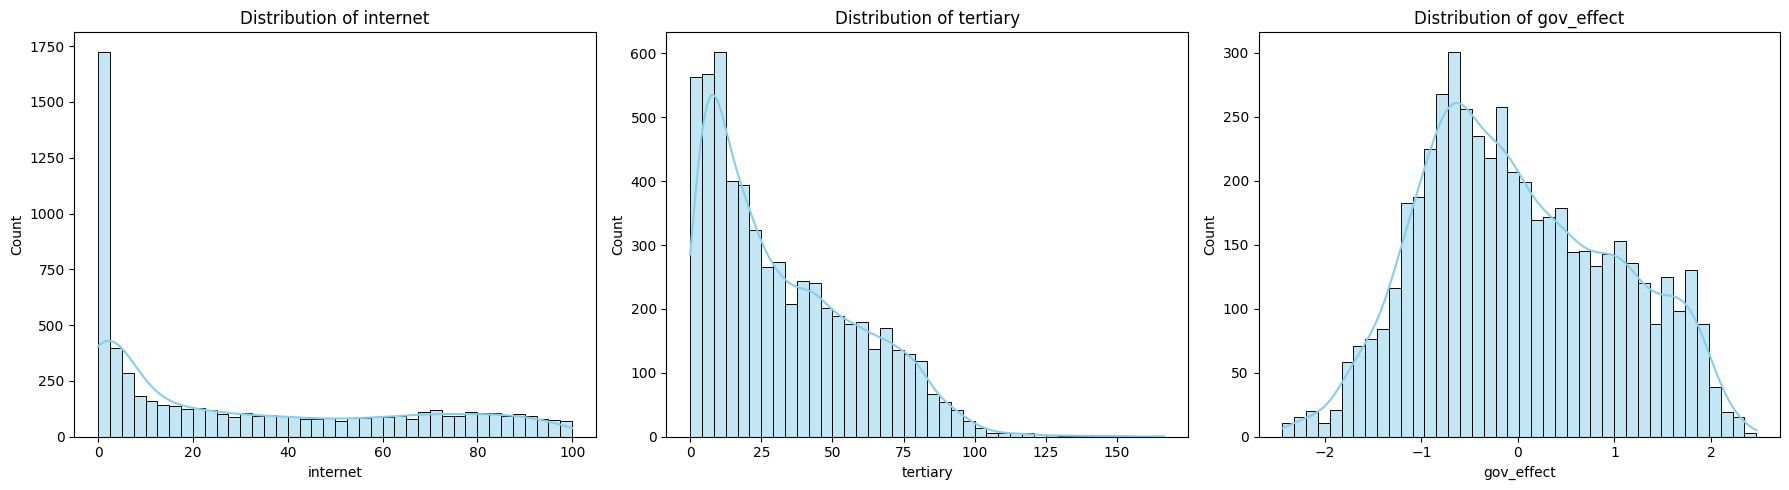

In [13]:
# Histograms for Medium Coverage Indicators

medium_indicators = ["internet", "tertiary", "gov_effect"]

plt.figure(figsize=(18, 5))

for i, col in enumerate(medium_indicators, 1):
    plt.subplot(1, 3, i)
    sns.histplot(
        data=combined_wide,
        x=col,
        kde=True,
        bins=40,
        color="skyblue"
    )
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.savefig("../images/medium_indicators_histograms.png", dpi=300)
plt.show()

---
## Notes on Histograms
---
Internet: Heavy clustering near zero shows many countries with little to no connectivity, but there’s a long right tail where some countries are pushing toward full penetration.

Tertiary education: Most values sit below ~30%, meaning higher education enrollment remains low across the continent, with very few outliers above 100%.

Government effectiveness: Distribution is fairly balanced around zero, with most countries between -1 and +1, highlighting wide governance disparities but no extreme skew.

Together, these indicators reinforce that Africa’s AI readiness hinges not just on infrastructure, but also education and governance capacity.

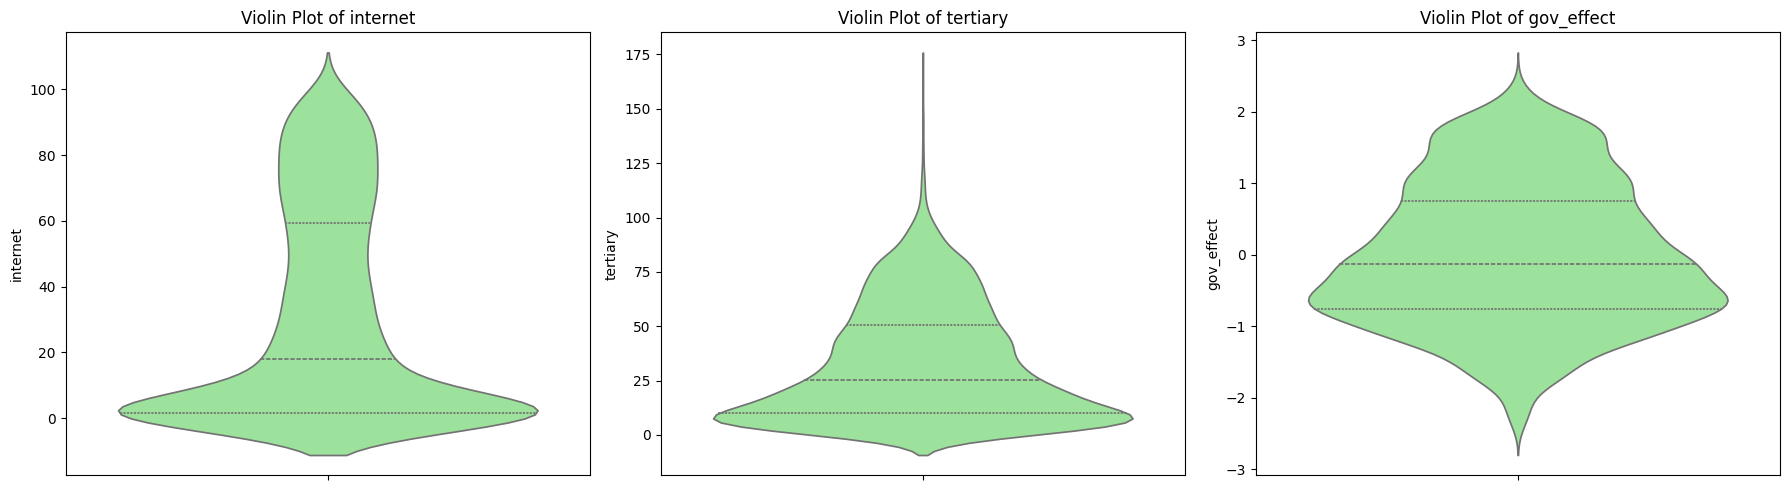

In [14]:
# Violin Plots for Medium Coverage Indicators

medium_indicators = ["internet", "tertiary", "gov_effect"]

plt.figure(figsize=(18, 5))

for i, col in enumerate(medium_indicators, 1):
    plt.subplot(1, 3, i)
    sns.violinplot(
        data=combined_wide,
        y=col,
        color="lightgreen",   # fixed color (safe, no warnings)
        inner="quartile"      # shows median + IQR
    )
    plt.title(f"Violin Plot of {col}")
    plt.ylabel(col)

plt.tight_layout()
plt.savefig("../images/medium_indicators_violin.png", dpi=300)
plt.show()

---
## Notes on Violins
---
Internet: The split density shows many countries still clustered near zero connectivity, but a distinct upper group is moving toward 60–100%, highlighting a widening digital divide.

Tertiary education: The density is heavily bottom-weighted, with most nations below 25%, reflecting limited higher education access and only a handful exceeding 50%.

Government effectiveness: Fairly balanced around zero, with density spread both negative and positive — reinforcing that governance quality varies widely but centers close to average.

These reinforce that infrastructure is racing ahead of education and governance, which could slow AI readiness despite rapid digital adoption.

---
## Weak Coverage Indicator EDA
---

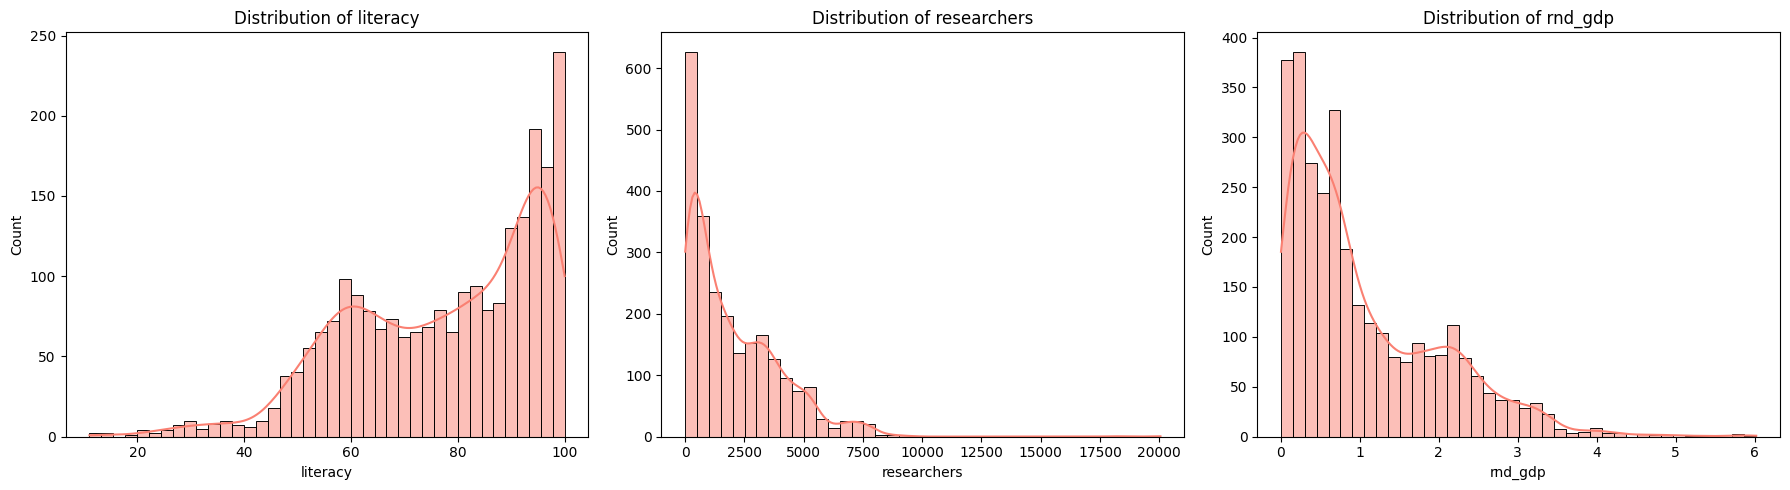

In [15]:
# Histograms for Weak Coverage Indicators

weak_indicators = ["literacy", "researchers", "rnd_gdp"]

plt.figure(figsize=(18, 5))

for i, col in enumerate(weak_indicators, 1):
    plt.subplot(1, 3, i)
    sns.histplot(
        data=combined_wide,
        x=col,
        kde=True,
        bins=40,
        color="salmon"
    )
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.savefig("../images/weak_indicators_histograms.png", dpi=300)
plt.show()

---
## Notes on Histograms
---
Literacy: Most countries cluster between 60–100%, but the spread below 50% shows persistent educational gaps that weaken human capital readiness.

Researchers per million: Extremely skewed, with many countries near zero and only a few with large research communities — underscoring capacity inequality in innovation.

R&D spending (% GDP): The majority sit below 1%, with a thin tail up to ~6% — suggesting research investment is minimal across most of Africa.

These are valuable for context, but their heavy missingness and skew mean they’re better as secondary indicators rather than core components of the AI readiness index.

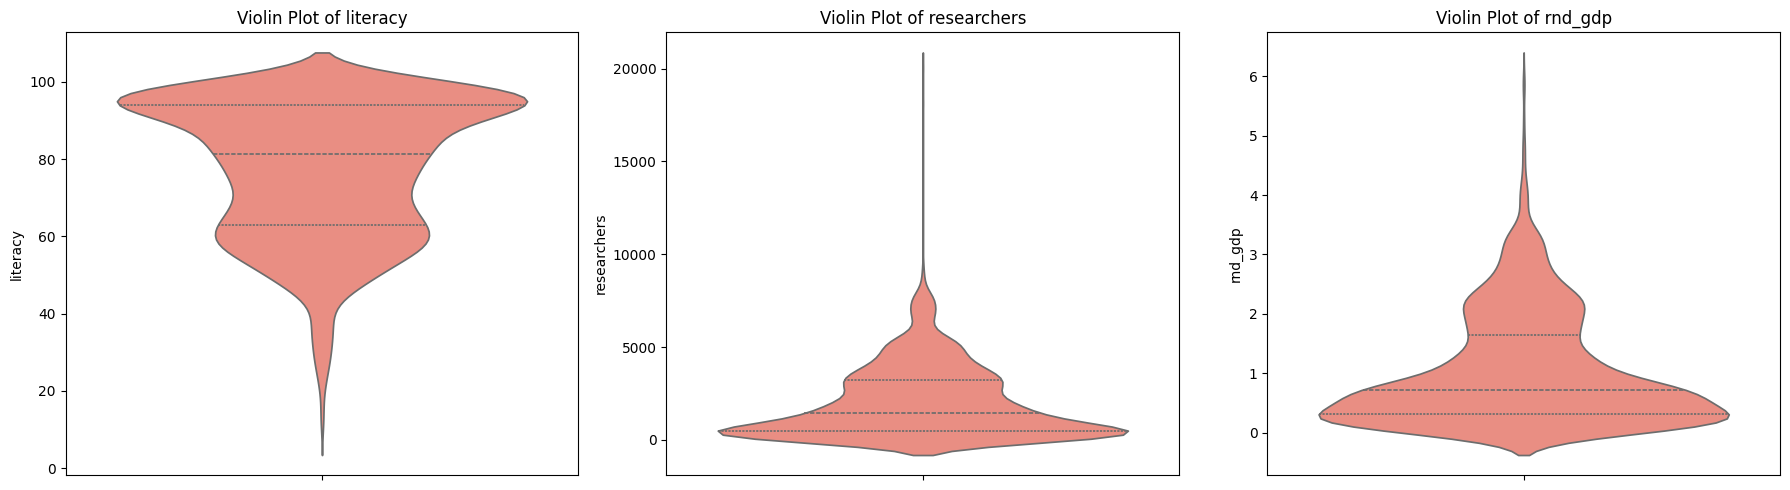

In [16]:
# Violin Plots for Weak Coverage Indicators

weak_indicators = ["literacy", "researchers", "rnd_gdp"]

plt.figure(figsize=(18, 5))

for i, col in enumerate(weak_indicators, 1):
    plt.subplot(1, 3, i)
    sns.violinplot(
        data=combined_wide,
        y=col,
        color="salmon",     # fixed single color (no warnings)
        inner="quartile"    # shows median + IQR
    )
    plt.title(f"Violin Plot of {col}")
    plt.ylabel(col)

plt.tight_layout()
plt.savefig("../images/weak_indicators_violin.png", dpi=300)
plt.show()

---
## Notes on Violins
---
Literacy: Most density lies between 60–100%, with a strong cluster above 90%, but the long taper below 50% shows deep educational inequality.

Researchers: Heavily bottom-loaded near zero, with just a thin stretch into the thousands — only a few countries sustain notable research capacity.

R&D spending: Most values cluster under 1% of GDP, with rare spikes up to 4–6%, underscoring how little is invested continent-wide.

These plots reinforce that while literacy has some strengths, research capacity and R&D remain the weakest pillars for AI readiness.

---
## Time Trend Analysis for Strong + Medium Indicators
---

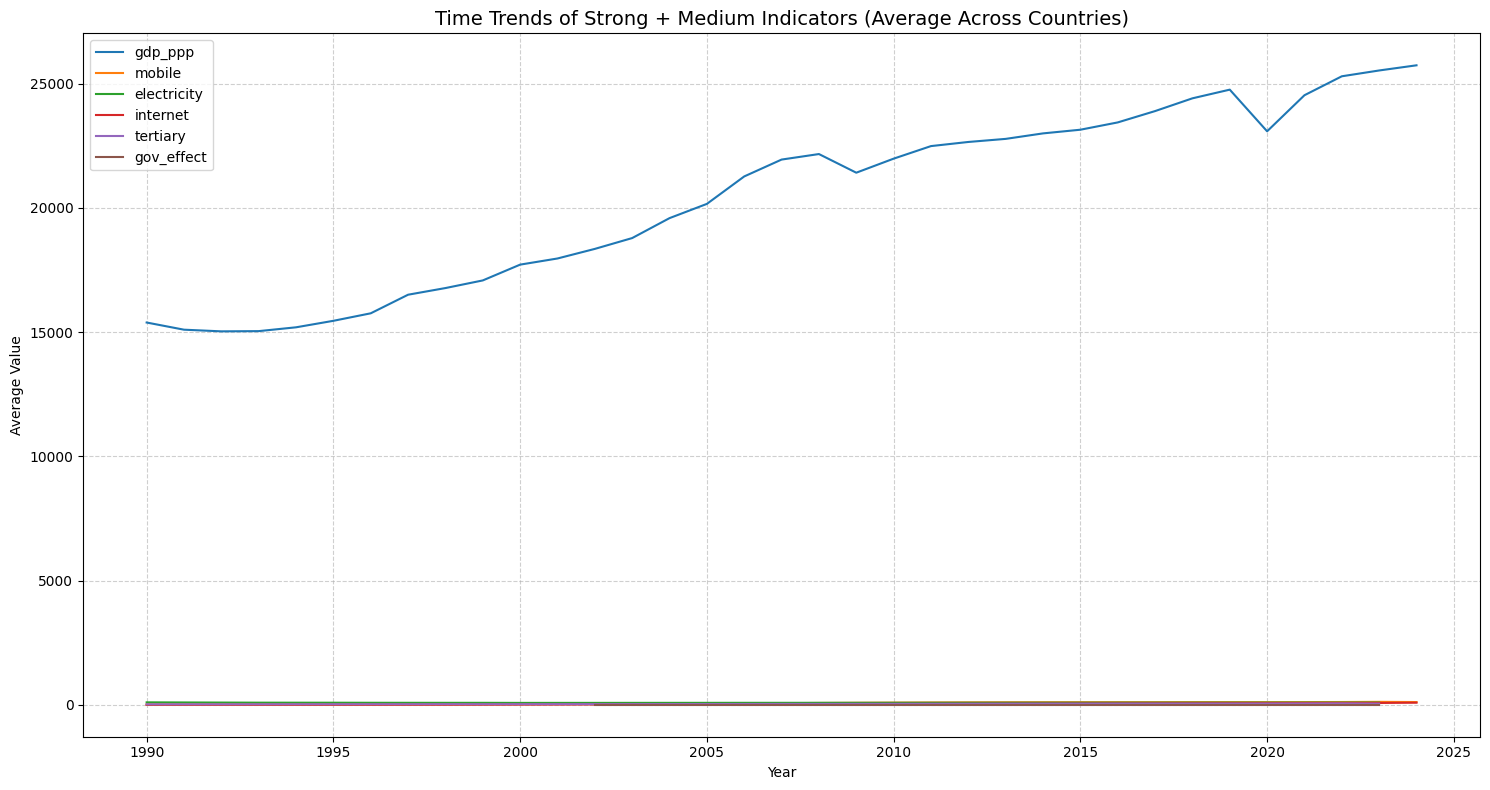

Indicator,gdp_ppp,mobile,electricity,internet,tertiary,gov_effect
Year,,,,,,
1990.0,15381.883721,0.241303,96.603436,0.024195,15.983961,NaN
1991.0,15093.148432,0.374228,92.224824,0.280388,17.420773,NaN
1992.0,15026.384672,0.524142,87.976218,0.399150,17.484755,NaN
1993.0,15035.309227,0.757167,83.855243,0.463648,18.457921,NaN
1994.0,15189.009758,1.194147,82.802294,0.665509,19.738712,NaN
1995.0,15450.412285,1.909637,81.958601,0.954370,20.224807,NaN
1996.0,15752.543570,2.878868,79.425662,1.460958,21.478828,-2.631999e-09
1997.0,16500.717024,4.324547,78.394713,2.472839,21.445202,NaN
1998.0,16768.464500,6.541742,77.491978,3.943222,23.667603,2.024614e-09


In [17]:
# Time-Trend Analysis for Strong + Medium Indicators

trend_indicators = ["gdp_ppp", "mobile", "electricity", "internet", "tertiary", "gov_effect"]

# Group by Year and compute mean (ignoring NaNs)
trend_data = combined_wide.groupby("Year")[trend_indicators].mean()

plt.figure(figsize=(15, 8))

for col in trend_indicators:
    plt.plot(trend_data.index, trend_data[col], label=col)

plt.title("Time Trends of Strong + Medium Indicators (Average Across Countries)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig("../images/time_trends_strong_medium.png", dpi=300)
plt.show()

# Quick peek at the trend data table (first 10 years)
trend_data.head(10)

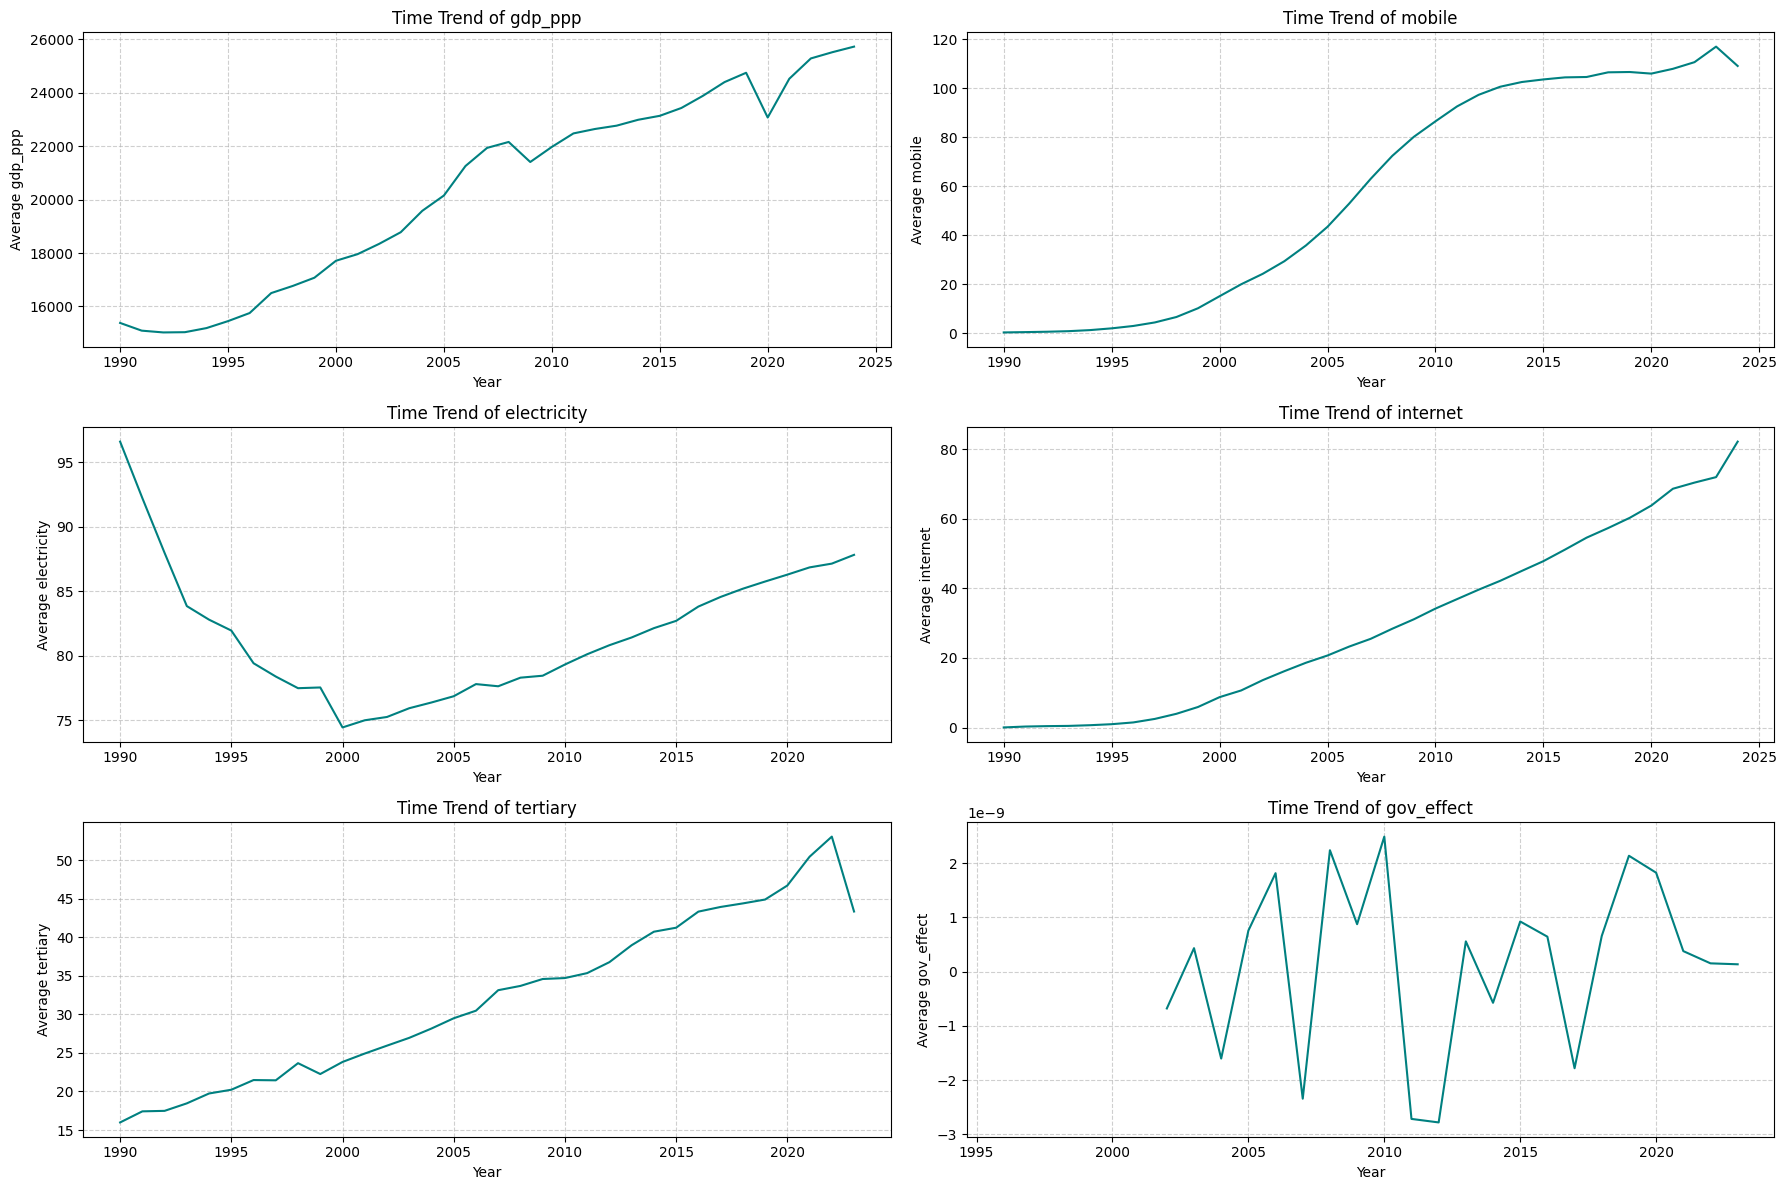

In [18]:
# Separate Time-Trend Plots for Strong + Medium Indicators

trend_indicators = ["gdp_ppp", "mobile", "electricity", "internet", "tertiary", "gov_effect"]

plt.figure(figsize=(18, 12))

for i, col in enumerate(trend_indicators, 1):
    plt.subplot(3, 2, i)
    plt.plot(trend_data.index, trend_data[col], color="teal")
    plt.title(f"Time Trend of {col}", fontsize=12)
    plt.xlabel("Year")
    plt.ylabel(f"Average {col}")
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig("../images/time_trends_separate.png", dpi=300)
plt.show()

---
## Notes on Graphs
---
GDP_PPP (top-left):
Steady, near-linear growth from ~15K in the early 1990s to ~26K in 2024. Despite some dips around 2008 and 2020 (likely global crises), the overall upward trajectory suggests improving economic capacity for tech adoption.

Mobile (top-right):
Explosive growth after 2000, peaking above 100% penetration by ~2015. This reflects the rapid mobile revolution in Africa, where SIM cards often exceed one per person. It plateaus recently, showing saturation.

Electricity (middle-left):
Decline in the 1990s, bottoming around 2000, followed by steady recovery and growth since then. Indicates infrastructure setbacks in the 90s but steady investment since — though progress is slower compared to mobile.

Internet (middle-right):
Almost nonexistent until ~2000, then sharp, steady exponential growth, now approaching ~80% average by 2024. A textbook digital leapfrog — and one of the clearest drivers of readiness.

Tertiary education (bottom-left):
Gradual increase from ~15% in 1990 to nearly 50% by 2020. Shows expansion in higher education access, though still lagging infrastructure. Dip after 2020 may reflect disruptions (COVID-19, instability).

Government effectiveness (bottom-right):
Volatile with no clear upward trend — swings between negative and slightly positive values. This highlights governance as the least predictable factor, with uneven progress across the continent.

## Overall take:

Infrastructure (mobile, internet, electricity) is showing strong upward trends → clear readiness enablers.

Human capital (tertiary) is improving but slower.

Governance is unstable, making it a wildcard for sustainable readiness.

GDP growth provides a stable economic backbone.

Together, this suggests Africa is technically racing forward (mobile + internet), but education and governance remain bottlenecks for AI readiness.

---
## Heatmap of Correlations (Static + Interactive)
---

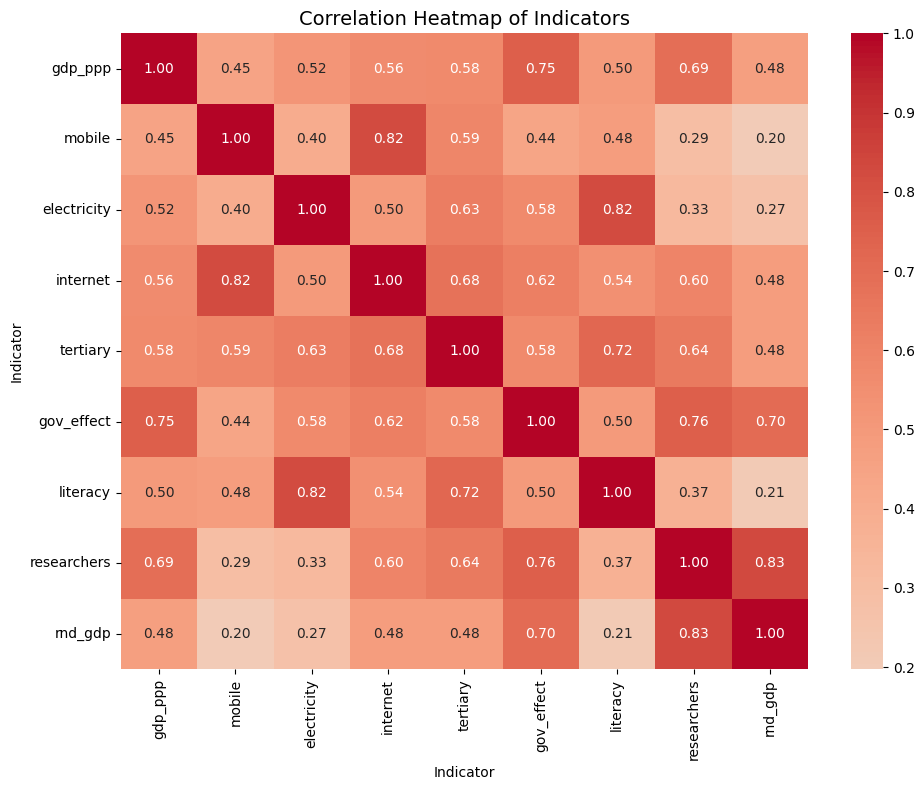

In [19]:
# Correlation Heatmap (Static + Interactive)

# Select numeric indicators only
corr_data = combined_wide[[
    "gdp_ppp", "mobile", "electricity", "internet", "tertiary", "gov_effect",
    "literacy", "researchers", "rnd_gdp"
]]

# Compute correlations
corr_matrix = corr_data.corr()

# --- Static Seaborn Heatmap ---
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Indicators", fontsize=14)
plt.tight_layout()
plt.savefig("../images/correlation_heatmap.png", dpi=300)
plt.show()

# --- Interactive Plotly Heatmap ---
import plotly.express as px

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    title="Interactive Correlation Heatmap of Indicators"
)
fig.show()

---
## Notes on Heatmaps
---
Strongest relationships:

internet ↔ mobile (0.82) — makes sense, since internet access is largely mobile-driven in Africa.

electricity ↔ literacy (0.82) — education flourishes where infrastructure is reliable.

researchers ↔ rnd_gdp (0.83) — higher R&D investment aligns with more research staff.

Economic drivers:

gdp_ppp correlates strongly with gov_effect (0.75) and researchers (0.69), suggesting that wealthier economies also have stronger governance and more research capacity.

Mixed signals:

gov_effect has balanced correlations (0.58–0.76 range), tying moderately to most indicators, but its volatility in time-trends means it’s less reliable as a consistent predictor.

mobile shows a weaker tie to governance (0.44), underscoring that connectivity can expand even in fragile states.

## Takeaway:
This confirms that infrastructure (electricity, mobile, internet) and education/research (literacy, tertiary, R&D) move together, while governance is linked but more volatile. For the readiness index, the heatmap suggests building on infrastructure + human capital as the backbone, with governance as a contextual modifier.

---
# Wrap-Up Summary of EDA Findings
---
=== EDA Wrap-Up (02_Snapshot) ===

1. Data Coverage:
   - Strong indicators (low missingness): GDP_PPP, Mobile, Electricity
   - Medium indicators (moderate missingness): Internet, Tertiary Education, Gov Effectiveness
   - Weak indicators (high missingness): Literacy, Researchers, R&D (% GDP)

2. Distribution Insights:
   - GDP_PPP: Right-skewed, most countries in low/mid range, few wealthy outliers.
   - Mobile: Rapid rise with bimodal spread (low vs. saturated adoption).
   - Electricity: Bimodal — some countries near universal, others still <30%.
   - Internet: Fast growth, but strong divide between high and low penetration states.
   - Tertiary: Mostly under 25%, gradual improvement with rare outliers.
   - Literacy: Many above 80%, but some countries still far behind.
   - Researchers & R&D: Highly skewed, concentrated near zero, weak overall capacity.

3. Time Trends:
   - GDP_PPP: Steady growth since 1990, dips during global crises.
   - Mobile & Internet: Explosive growth post-2000; mobile near saturation, internet still climbing.
   - Electricity: Decline in the 90s, slow recovery since 2000.
   - Tertiary: Gradual increase to ~50%, disrupted post-2020.
   - Gov Effectiveness: Volatile, no clear upward trajectory.

4. Correlations:
   - Strong ties: Internet ↔ Mobile (0.82), Electricity ↔ Literacy (0.82), Researchers ↔ R&D (0.83).
   - GDP strongly linked with governance (0.75) and research capacity (0.69).
   - Governance connects broadly but inconsistently — a contextual modifier.

=== Key Takeaways for Readiness Index ===
- Infrastructure (mobile, internet, electricity) forms the strongest and most consistent foundation.
- Human capital (tertiary, literacy, research, R&D) is improving but remains uneven.
- Governance is influential but unstable — should be weighted carefully.
- Next step (03_Normalize): scale indicators (0–100) for comparability and design the composite AI Readiness Index.

